# Opis zadania

Na podstawie zbioru (https://www.kaggle.com/zozolla/polish-craft-beer-labels) należy wybrać maksymalnie 50% (można mniej) danych i wytrenować klasyfikator o dokładności 70-80% o dowolnej architekturze i budowie. (framework dowolny)

Należy przedstawić wyniki jakości klasyfikatora (ewaluacja modelu).

Zrobić inferencję, zwizualizować błędy i dokonać ich podziału (np model nie rozpozanje klasy x lub nie radzi sobie z przykładami o kolorze y).

Zaproponować rozwiazanie napotkanych problemów przy założeniu, że nie można dorzucić więcej danych.

# Pobieranie i wczytywanie zbioru danych


In [ ]:
!pip install -q kaggle

In [ ]:
# Choose the kaggle.json file that you downloaded
from google.colab import files 
files.upload()

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d zozolla/polish-craft-beer-labels

 88% 117M/133M [00:00<00:00, 297MB/s] 
100% 133M/133M [00:00<00:00, 270MB/s]


In [ ]:
!unzip polish-craft-beer-labels.zip

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

%matplotlib inline
# plt.rcParams['figure.figsize'] = [24, 24]


In [ ]:
batch_size = 32
img_height = 299
img_width = 299
data_dir = 'beer_labels'

In [ ]:
# Train dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.5,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 8007 files belonging to 100 classes.
Using 4004 files for training.


In [ ]:
# Validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.5,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 8007 files belonging to 100 classes.
Using 4003 files for validation.


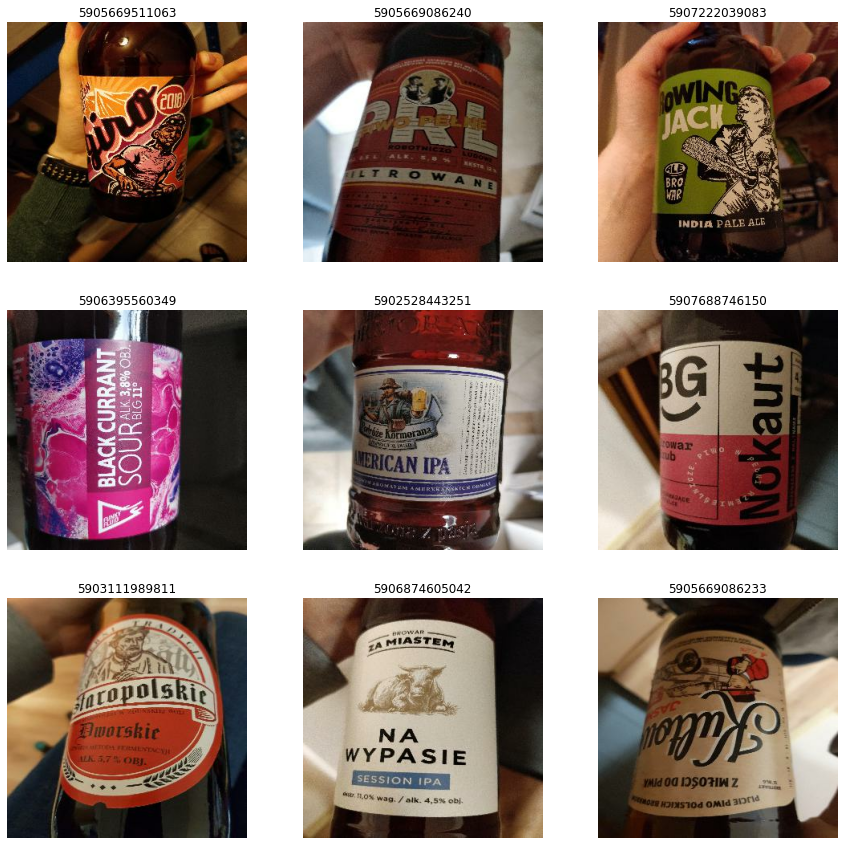

In [ ]:
# Visualization of some classes
class_names = train_ds.class_names

plt.figure(figsize=(15, 15))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [ ]:
# Configure the dataset for performance

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Trening modelu

In [ ]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 299, 299, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 299, 299, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 149, 149, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 149, 149, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 74, 74, 64)        1

In [ ]:
# Training
epochs=20

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
126/126 [==============================] - 30s 114ms/step - loss: 4.3290 - accuracy: 0.0774 - val_loss: 3.3418 - val_accuracy: 0.2293
Epoch 2/20
126/126 [==============================] - 8s 65ms/step - loss: 1.7463 - accuracy: 0.5672 - val_loss: 1.3348 - val_accuracy: 0.6453
Epoch 3/20
126/126 [==============================] - 8s 65ms/step - loss: 0.4093 - accuracy: 0.8914 - val_loss: 1.0195 - val_accuracy: 0.7282
Epoch 4/20
126/126 [==============================] - 8s 65ms/step - loss: 0.1087 - accuracy: 0.9753 - val_loss: 0.8856 - val_accuracy: 0.7852
Epoch 5/20
126/126 [==============================] - 8s 65ms/step - loss: 0.0277 - accuracy: 0.9953 - val_loss: 0.8503 - val_accuracy: 0.7962
Epoch 6/20
126/126 [==============================] - 8s 65ms/step - loss: 0.0126 - accuracy: 0.9965 - val_loss: 1.2318 - val_accuracy: 0.7532
Epoch 7/20
126/126 [==============================] - 8s 66ms/step - loss: 0.0948 - accuracy: 0.9773 - val_loss: 1.2947 - val_accuracy: 0.73

# Walidacja modelu

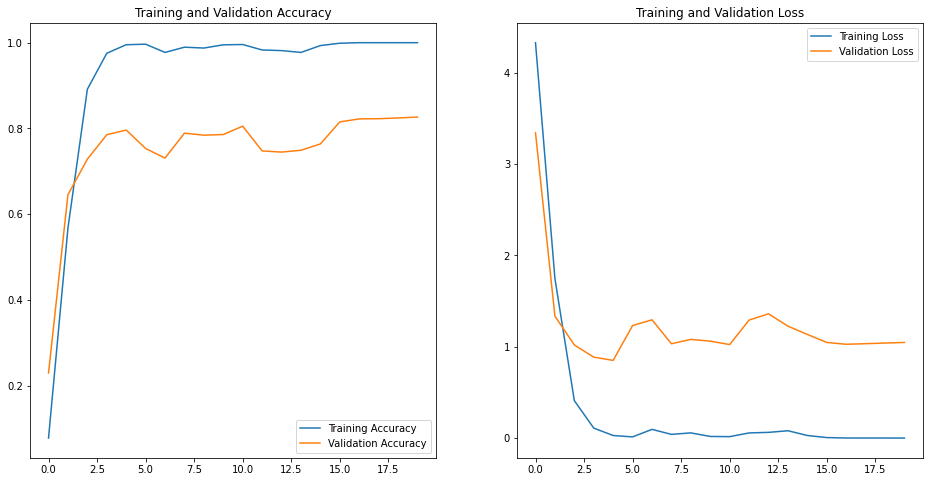

In [ ]:
def visualize_training(history, epochs):
  """Function to visualize train/val loss and accuracy"""

  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(16, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')

  plt.show()


visualize_training(history, epochs)

In [ ]:
# Get actual and predicted labels
y_val_true, y_val_preds = [], []

for images, targets in val_ds:
  y_pred = model.predict(images).argmax(axis=1)
  y_val_preds.extend(y_pred)
  y_val_true.extend(targets.numpy())


In [ ]:
print(len(y_val_preds))
print(y_val_preds[:10])

4003
[96, 74, 0, 61, 69, 16, 11, 93, 60, 59]


In [ ]:
print(len(y_val_true))
print(y_val_true[:10])

4003
[96, 98, 44, 61, 69, 16, 15, 93, 60, 59]


In [ ]:
# Calculate classification report and confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

print(classification_report(y_val_true, y_val_preds))

              precision    recall  f1-score   support

           0       0.87      0.94      0.90        49
           1       0.79      0.79      0.79        34
           2       0.74      0.77      0.75        26
           3       0.74      0.93      0.82        40
           4       0.70      0.53      0.60        40
           5       0.75      0.73      0.74        45
           6       0.59      0.64      0.61        36
           7       0.73      0.97      0.84        34
           8       0.83      0.97      0.89        30
           9       0.65      0.84      0.73        31
          10       0.74      0.82      0.78        34
          11       0.88      0.80      0.84        45
          12       0.68      0.43      0.53        35
          13       0.90      0.90      0.90        39
          14       0.90      0.98      0.94        45
          15       0.85      0.75      0.80        44
          16       0.86      0.98      0.92        50
          17       0.88    

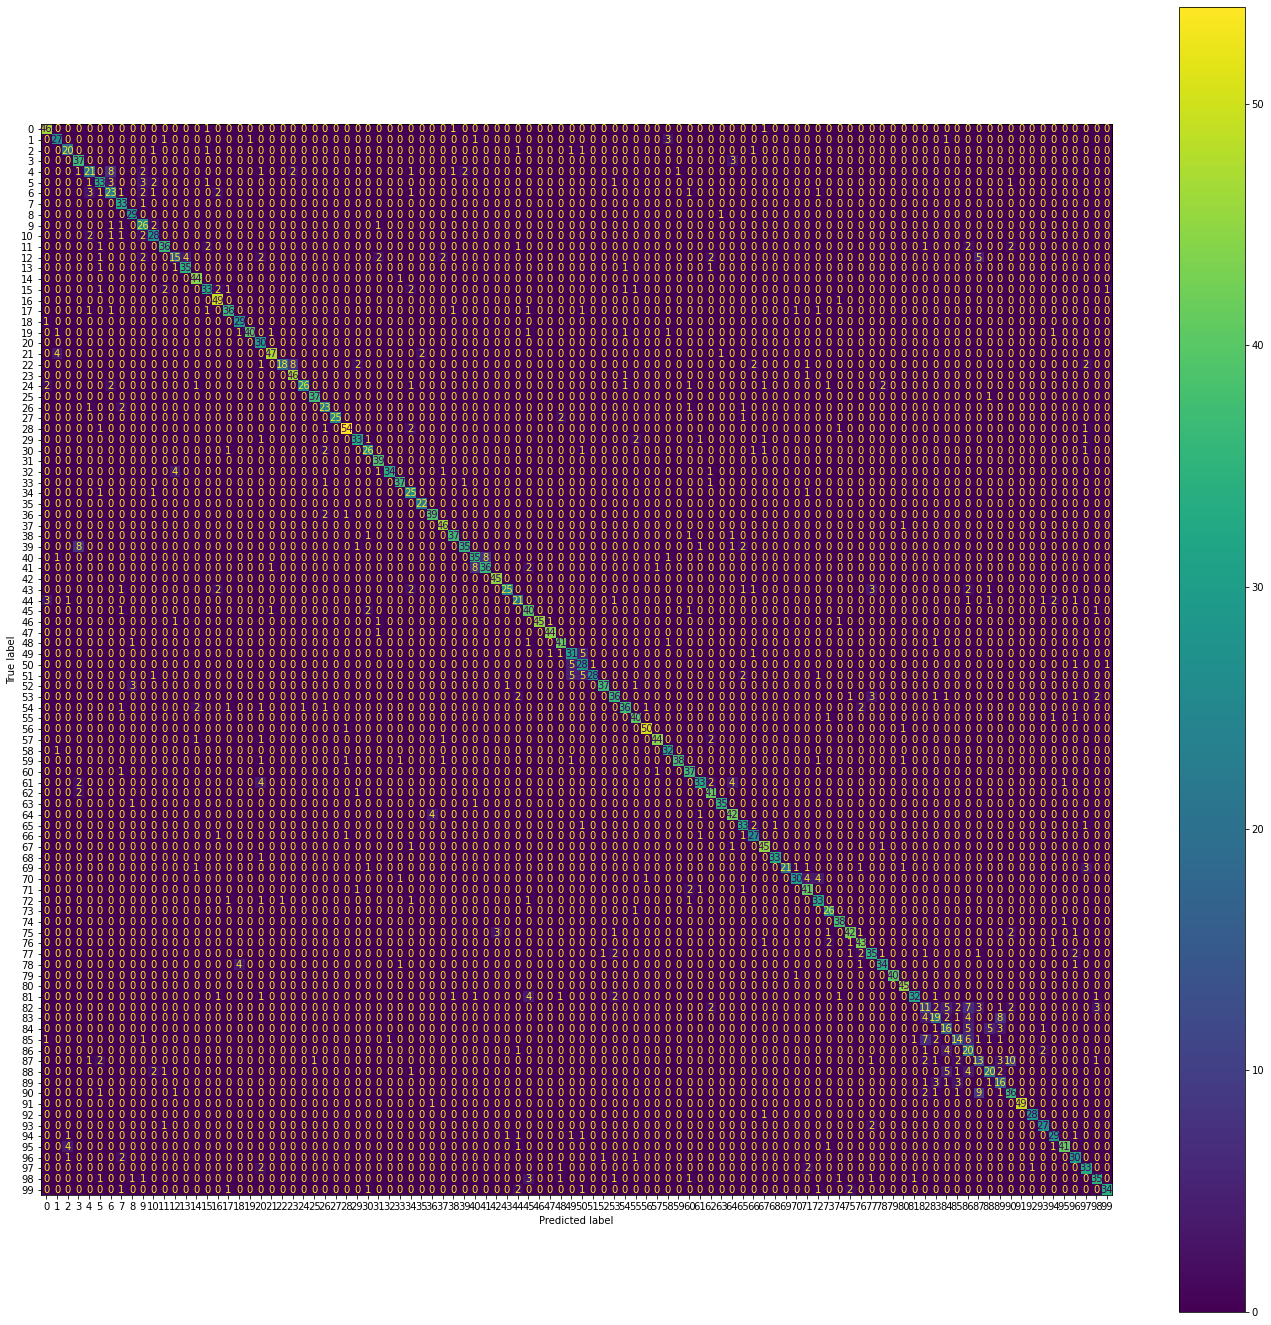

In [ ]:
cm = confusion_matrix(y_val_true, y_val_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

plt.figure(figsize=(32, 24))
plt.show()

# Data augmentation + Dropout


> Znacznie lepsze wyniki na zbiorze treningowym, niż testowym, wskazują na tzw. **overfitting**, czyli nadmierne dopasowanie modelu do zbioru uczącego. Należy zastosować pewne metody regularyzacji


> Chociaż nie można dorzucić więcej danych treningowych, można wygenerować je sztucznie za pomocą tzw. **augmentacji zbioru danych**. Polega ona na zastosowaniu różnych transformacji do każdego obrazu treningowego - translacje, rotacje, odbicie, powiększanie itp. W rezultacie ilość danych trenigowych zwiększa się kilkukrotnie.


> Dodano także warstwę **dropout** przed ostatnimi warstwami FC. Dropout losowo zeruje wyjścia niektórych jednostek, co pozwala zmniejszyć overfitting.


> Można zastosować także tzw. callback, który sprawdza pod koniec każdej epoki, czy osiągnieto zadaną dokładność klasyfikacji na zbiorze testowym, jeśli tak, trening jest przerywany


> Zastosowanie powyższych technik poprawiło dokładność klasyfikacji **z około 82% na 95%**



In [ ]:
data_augmentation = Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height, img_width, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

IMG_RESIZE = 256

resize_and_rescale = Sequential([
  layers.Resizing(IMG_RESIZE, IMG_RESIZE),
  layers.Rescaling(1./255)
])

In [ ]:
model_aug = Sequential([
  data_augmentation,
  resize_and_rescale,

  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Dropout(0.4), # Randomly drop 40% connections
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

model_aug.compile(optimizer="Adam",
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model_aug.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 299, 299, 3)       0         
                                                                 
 sequential_2 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 128, 128, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                  

In [ ]:
# Writing own callback, which stops trainging when val_acc > 0.95

class myCallback(tf.keras.callbacks.Callback):

  def on_epoch_end(self, epoch, logs={}):
    if logs.get('val_accuracy') > 0.95:
      print("\nReached 95% validation accuracy so cancelling training!")
      self.model.stop_training = True


callback = myCallback()

In [ ]:
# Longer training
epochs = 40

history_aug = model_aug.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[callback]
)

Epoch 1/40
126/126 [==============================] - 9s 59ms/step - loss: 4.1092 - accuracy: 0.0959 - val_loss: 3.4647 - val_accuracy: 0.1966
Epoch 2/40
126/126 [==============================] - 7s 57ms/step - loss: 2.5141 - accuracy: 0.3649 - val_loss: 1.7646 - val_accuracy: 0.5289
Epoch 3/40
126/126 [==============================] - 7s 57ms/step - loss: 1.3514 - accuracy: 0.6229 - val_loss: 0.9554 - val_accuracy: 0.7275
Epoch 4/40
126/126 [==============================] - 7s 56ms/step - loss: 0.8340 - accuracy: 0.7502 - val_loss: 0.6463 - val_accuracy: 0.8039
Epoch 5/40
126/126 [==============================] - 7s 56ms/step - loss: 0.6024 - accuracy: 0.8274 - val_loss: 0.7317 - val_accuracy: 0.7999
Epoch 6/40
126/126 [==============================] - 7s 56ms/step - loss: 0.4821 - accuracy: 0.8482 - val_loss: 0.4673 - val_accuracy: 0.8546
Epoch 7/40
126/126 [==============================] - 7s 56ms/step - loss: 0.3961 - accuracy: 0.8749 - val_loss: 0.5018 - val_accuracy: 0.8461

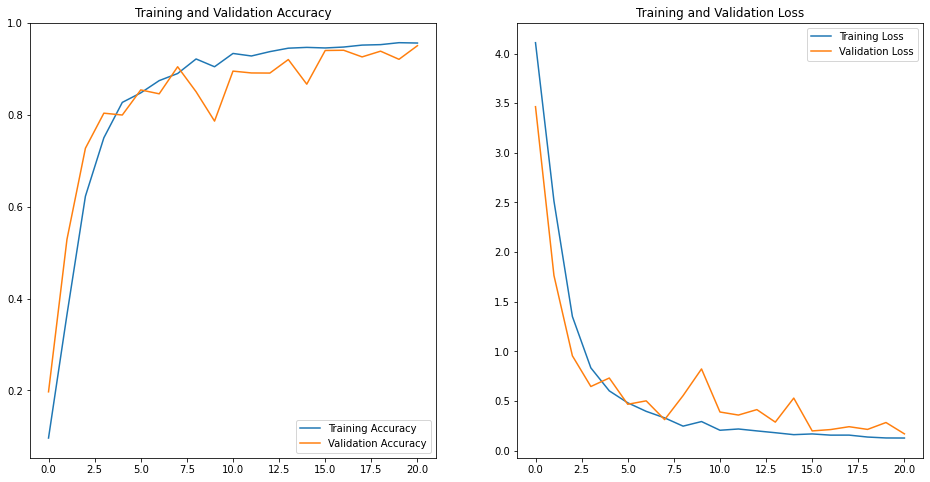

In [ ]:
visualize_training(history=history_aug, epochs=21)